# <b>Predicting on user images</b>

This notebook documents the process of defining all functions that in my mind are and will be necessary to give model into the hands of a regular user. 

This is a mandatory part and a logical next step in the development of a standalone app, becuase here I allow user to actually experience the model, play with it and see if it can predict correct breeds on the images of dogs they took, saw in memes or wherever they got them from. From this point onward I will be able to gather new images with either correct breeds or ones I will have to verify myself (but based on user suggestion).

At the time of writing this entry (26.05.2023) I am still missing the step of forwarding the labeled predictions to a central location, because they are only stored locally. I will take care of this when I'll get down to creating functions that would take those images and add them to the labels.csv and actual training data folder.

### What is all this?

If you are new here, <b>hi</b>! This is an extension of my previously released notebook called "IdentiBreed". You can find the original notebook <a href="https://github.com/Ale-Cie/IdentiBreed/blob/main/IdentiBreed.ipynb">here</a> and the entire repository right <a href="https://github.com/Ale-Cie/IdentiBreed">here</a>. This is basically a project started during an online course, which I'm now expanding for bragging reasons and as an attempt at putting my knowledge to the test.

IdentiBreed is a transfer (currently but probably not forever) neural network that attempts to identify dog breeds based on provided images. The model has been already created, now I'm working on the user side of things. Next step is probably putting all this in a nice window instead of a notebook.

Without furhter ado, let's get down to this notebook!

## Loading necessary tools

We start by importing all tools that will be necessary. A new addition is loading in my new `model_funcs.py` from the './resources/' file, which contains all functions defined in the original `IdentiBreed.ipynb`. They will be usefull to work with the model and feed it user's images.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import subprocess

from resources import model_funcs

from IPython.display import Image
from sklearn.model_selection import train_test_split
from PIL import Image

Here we load in the actual model and name it `identibreed` for ease of use. And partially because I like this name...

In [2]:
identibreed = model_funcs.load_model(
    model_path= "./models/20230511-14531683809630-full-image-set-MobileNetV2-Adam-v2.h5"
)

Loading saved model from: ./models/20230511-14531683809630-full-image-set-MobileNetV2-Adam-v2.h5...
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



## Defining functions

In order to somewhat simplify the process of predicting, saving and plotting images we will declare functions that will handle all those tasks separately.

Let's begin with `predict_user_images()` - a function that will take the images and `unique_labels` and using other functions defined in `model_funcs.py` will predict the labels. What it will return will be a list of image paths and a list of dictionaries, each containing important elements for later:

- Image - a singular tensor on which prediction was made
- Predicted breed - pretty self explanatory
- Accuracy - The metric of choice, it will describe how certain the model is that the prediction is correct
- Top 5 labels - The predicted label and four others, all of them being the highest confidences in the whole prediction
- Top 5 confidence values - Actual values of confidences for the mentioned above labels

In [3]:
def predict_user_images(file_paths, unique_labels):
  """
  This function takes a path to the user input directory and the unique_labels list.
  It makes model create predictions of dog breeds present in user's images.
  The function creates a list of dictionaries for each image. 
  These dictionaries contain the image tensor, predicted breed, model's confidence, four other probable breeds and their confidences.

  Returns list of image paths and list of image dictionaries. 
  """

  # Instantiating empty lists for image paths and image dictionaries
  dir_list, predicted_files = [], []
  print("Predicting dog breeds from images in './images' folder.")
  print("This could take a moment...")
  for file in os.listdir(file_paths):
    try:
      img_path = file_paths + "/" + file

      # We turn each image into it's own minibatch and feed it into the model
      img = model_funcs.minibatch_maker(X=[img_path], batch_size=32, test_data=True)
      prediction = identibreed.predict(img, verbose=0)

      # Based on the highest probability we get the breed label and the next four with highest probability
      pred_label = model_funcs.name_predicted_label(prediction, unique_labels)
      top_5_preds = prediction.argsort()[0][-5:][::-1]

      # We create a new `predicted_files` entry 
      pred_dict = {
        "image": model_funcs.turn_to_tensor(img_path), # Tensor for ease of displaying later
        "prediction": pred_label, # The dog breed predicted by the model
        "accuracy": ("%.3f" %(np.max(prediction[0]) * 100)), # Probability in percentage
        "top_5_labels": unique_labels[top_5_preds], # Top 5 predicted labels
        "top_5_confidences": prediction[0][top_5_preds] # Top 5 confidences
      }

      # We append the dictionary to the list and an image file path into another list
      predicted_files.append(pred_dict)
      dir_list.append(img_path)
    except:
      pass
      

  return dir_list, predicted_files


Next up is `image_saver()` which depending on the keyword arguments will either save the images in a 'user_submissions' folder (images that will be used somewhere in the future for retraining the model) or in 'output' folder.

In [4]:
def image_saver(image, breed_label, accuracy= None, data_expansion= False, prefix= None):
    """
    This function takes an image, breed label and optionally:
        - accuracy: Model's confidence of the prediction being correct
        - data_expansion: True if we want to save images as future dataset expansion submissions
        - prefix: string if we want to mark user submitted breed for future reference

    It saves the image either into './user/output' if data_expansion is False or './data/user_submissions' if data_expansion is Truefolder.

    Returns nothing.
    """
    # We get the current time in order to add as a suffix to the file name
    date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # This block runs when the predicted breed was evaluated by the user
    if data_expansion:
        print("Currently images are only stored locally, they are not sent to the staff.")
        print("Adding image to the training dataset...")
        with Image.open(image) as img:
            if not prefix:
                # This line runs in two scenarios:
                # 1) The prediction was correct from the get go
                # 2) The prediction was incorrect, but user provided a breed that exists within the unique_labels list
                img.save(f"./data/user_submissions/{breed_label}_{date}.jpg")
            else:
                # This line runs in another two scenarios:
                # 1) Person running the code wants to differentiate certain saved images
                # 2) The intended scenario - user has provided a breed name three times, but it wasn't present in the unique_labels.
                # User is certain that what he provides is correct, function saves it with an originally intended prefix.
                # The intended prefix is 'US' as in User Submitted. It gets specified elsewhere in the repository
                img.save(f"./data/user_submissions/{prefix}_{breed_label}_{date}.jpg")
    
    # This block runs when user agreed to saving the images with predicted labels and top five predictions
    # The image here is really a matplotlib figure
    else:
        print("Prediction saved to 'IdentiBreed/user/output/' directory.")
        prediction_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        filename = f"{breed_label}_{accuracy}%_{prediction_date}.jpg"
        image.savefig(f"./user/output/{filename}", bbox_inches= "tight")

`open_directory()` is a simple enough function - it asks the user if they want a specified folder opened for them

In [5]:
def open_directory(directory_name):
  """
  This function ask the user if they want a folder opened for them.
  If they say yes, function opens a specified folder within './user/' directory in a new window.
  """

  open_loop = True

  while open_loop:
    open_folder = input(f"Would you like me to open {directory_name}? [Y/N]").lower()
    if open_folder == "y":
      try:
        subprocess.run(["start", f"./user/{directory_name}"])
      except:
        subprocess.run(["open", f"./user/{directory_name}"])
      open_loop = False
    elif open_folder == 'n':
      open_loop = False 
    else:
      print("Error, please try again!")

This dumpster fire of a function below (`data_expander()`) goes through each prediction and asks user, if the breed it predicted is correct. If yes, it saves the image in './data/user_submissions'. If the prediction wasn't correct the user is given an option to provide an actual breed or pass.

In [6]:
def data_expander(image_path, breed_label, unique_labels):
    """
    This function takes an image path, breed label and the unique labels list.
    As it runs it asks the user if the model's prediction was correct.
    Depending on the users evaluation:
        - Correct Prediction: the image is saved into './data/user_submissions' directory with the breed label and date as file name
        - Incorrect Prediction: User is asked if they can provide the correct breed. Depending on their answer:
            * Answer in unique_labels: Image is saved into './data/user_submissions' with the answer and date as a file name
            * Answer not in unique_labels: User is told their breed was not found in the database. User is asked if they want to try again:
                - User agrees: After third try the breed specified by the user is added a prefix of 'US' (as in User Submitted) and saved to './data/user_submissions' as prefix_breed_date.jpg
                - User disagrees: The image is omitted from saving to './data/user_submissions'
            * User declines: The image is omitted from saving to './data/user_submissions'

    Returns nothing.
    """
    

    # Here we start the first loop that user won't break out of until the image is either saved or omitted
    evaluation_loop = True
    while evaluation_loop:
        # We  assume that the user knows the correct breed of the dog present in the image and ask for their evaluation
        correct_flag = input("Was my prediction correct? [Y/N]").lower()
        
        # This block runs if the prediction was correct. It just runs the saver function and then ends the evaluation loop
        if correct_flag == "y":
            image_saver(
                image= image_path,
                breed_label= breed_label,
                data_expansion= True
            )
            evaluation_loop = False
        
        # Here we delve deeper since user says the prediction was not correct. 
        # We will be measuring attempts of breed name input and on the third incorrect one user will be asked to input the breed they think is correct
        elif correct_flag == "n":
            attempt = 1
            
            # Before we start another loop we ask the user if they know the correct breed. 
            # If they say they do we start the loop, if not we end the function
            correction_loop = True
            user_label_flag = input("Do you know the correct dog breed? [Y/N]").lower()
            while correction_loop:
                if user_label_flag == "y":

                    # Now based on user input we check if the breed is present in the 'unique_labels'
                    # Before that however we make edits to the breed provided so that it's in style of other breeds from labels.csv
                    breed_label = input("What was the correct dog breed?").lower().replace(" ", "_")
                    if breed_label in unique_labels:
                        
                        # We save the image because the breed was in the 'unique_breeds', then we close out of both the correction and evaluation loops
                        image_saver(
                            image= image_path,
                            breed_label= breed_label,
                            data_expansion= True
                        )
                        evaluation_loop, correction_loop = False, False
                    
                    # We now go on a bit of a ride - user provided an unknown or incorrect breed, we have to check what's going on
                    else:
                        try_again_loop = True
                        while try_again_loop:
                            
                            # This code is actually last to run but I've put it at the top to make sure it runs when it's needed.
                            # (I know I could reverse it, but it works and I really don't care enough now)
                            # With this if statement we allow user to save na image with the breed he THINKS is correct, but was not recognized three times
                            # However we run the 'image_saver()' function with a prefix 'US'. Then we close ot of all three loops
                            if attempt == 3:
                                user_breed = input("Specified breed not present in the database. Please write down the correct name of the breed. Our staff will manually check it and add to the database if correct.").lower()
                                image_saver(
                                    image= image_path,
                                    breed_label= user_breed,
                                    data_expansion= True,
                                    prefix= "US"
                                )
                                evaluation_loop, correction_loop, try_again_loop = False, False, False
                            
                            # This is a block of code that runs for the most of this loop. We ask for input and count how many attempts have already taken place
                            # If user says they don't want to try again we close all the loops.
                            # However, if they want to try again we give them the chance and add 1 to the attempt variable.
                            else:
                                again = input(f"Attempt {attempt}/3. Dog breed not found in the database. Would you like to try again? [Y/N]").lower()
                                if again == "y":
                                    attempt += 1
                                    try_again_loop = False
                                elif again == "n":
                                    print("Thank you for your cooperation. This breed is not yet supported and the image will not be used for further training purposes.")
                                    evaluation_loop, correction_loop, try_again_loop = False, False, False
                                else:
                                    print("Error, please try again.")
                            
                elif user_label_flag == "n":
                    print("Thank you for your cooperation. This image will not be used for further training purposes.")
                    evaluation_loop, correction_loop = False, False
                    
                else:
                    print("Error, please try again.")
                    user_label_flag = input("Do you know the actual dog breed? [Y/N]").lower()

        else:
            print("Error, please try again.")


And we get to the final function in this notebook - `show_user_images()`. This will run all previous functions while as well plotting each prediction. Beter to show than explain really.

In [7]:
def show_user_images(file_paths):
    """
    This function takes a path to input images and goes through predicting, plotting to saving images.
    """

    unique_labels = model_funcs.unique_labels_maker(
    labels_csv_path= "./data/labels.csv"
    )
    
    # First thing to do is attempt to open the './user/input' directory so that the user can put their images for predictions
    open_directory("input")
    
    # Now a quick loop helps us stall the user until they decide that they've added enough images 
    ready_flag = True
    while ready_flag:
        done_input = input("Have you added all the photos? [Y/N]").lower()
        if done_input == "y":
            ready_flag = False
        elif done_input == 'n':
            pass
        else:
            print("Error, please try again!")
    
    # We call the prediction function and retrieve a list of images (file paths) and the list of dictionaries with predicted images and other data
    image_list, predicted_files = predict_user_images(file_paths, unique_labels)
    rows = len(predicted_files)

    # Before going further we ask the user if they wan't to save their predicted images into output folder.
    # We assume at the current stage of the project that user wants to submit their images for 'database extension'
    # Really, now these images are only saved locally, so that's not a concern now 
    save_imgs = input("Would you like to save prediction results? [Y/N]").lower()
    while save_imgs not in ["y", "n"]:
        save_imgs = input("Would you like to save prediction results? [Y/N]").lower()
    # Here we go plotting results of the prediction.
    # We create a new figure with two subaxes for each prediction, which we can later easily save
    # On the left of the figure we will be plotting a resized image with a title of 'I am X% sure it's a PREDICTION'
    # On the right we will plot a bar graph containing top five predictions
    for i in range(rows):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        prediction_dict = predicted_files[i]
        ax1, ax2 = axs[0], axs[1]
        ax1.imshow(prediction_dict["image"])
        ax1.set_title(f"I am {prediction_dict['accuracy']}% sure it's a {prediction_dict['prediction']}")
        ax1.set_yticks([])
        ax1.set_xticks([])
        ax2.bar(
            x=np.arange(len(prediction_dict["top_5_labels"])),
            height= prediction_dict["top_5_confidences"],
            color= "tab:gray",

        )
        ax2.set_title("Top 5 probable breeds")
        ax2.set_xticks(
            np.arange(len(prediction_dict["top_5_labels"])),
            labels= prediction_dict["top_5_labels"],
            rotation="vertical"
        )
        bars = ax2.containers[0]
        ax2.bar_label(bars, labels = [f'{x.get_height():.3%}' for x in bars])
        plt.show()

        # Now if user said they want to save their predicted images that's where we go saving each of them into './user/output' folder
        if save_imgs == "y":  
            image_saver(
                image= fig,
                breed_label= prediction_dict["prediction"],
                accuracy= prediction_dict["accuracy"],
            )
        else:
            pass

        # This function runs for each prediction and saves or omitts an image to './data/user_submissions'
        data_expander(
            image_path= image_list[i],
            breed_label= prediction_dict["prediction"],
            unique_labels= unique_labels
        )

    # At the very end we ask the user if they want us to open the 'output' folder for them
    open_directory("output")

## Actual predictions

These images below are the ones I used while testing my functions, they also were great for experimentation, since some of them were not recognized correctly. When I knew the breeds I could correct them, and on one image I had to pass since I had no idea what breed it is.
These photos also helped me understand that there's no 'english_bulldog' breed in the `unique_labels`...

Predicting dog breeds from images in './images' folder.
This could take a moment...


2023-05-26 17:54:11.294977: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


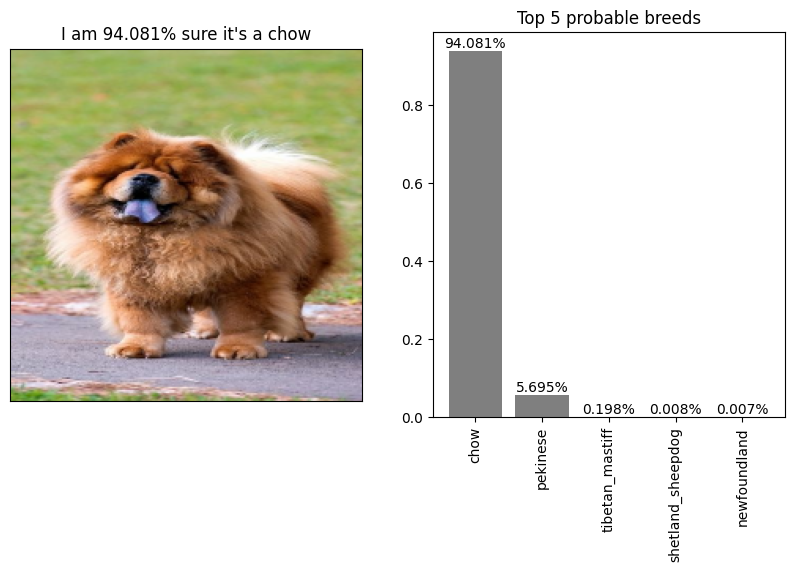

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


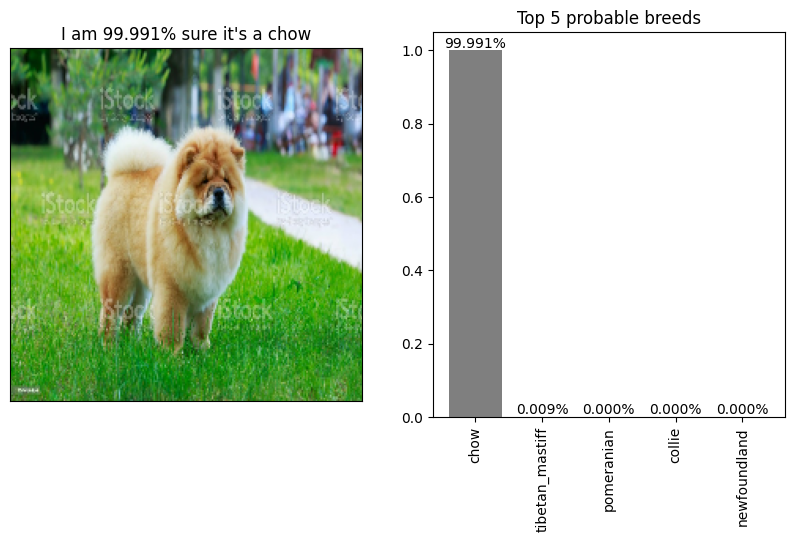

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


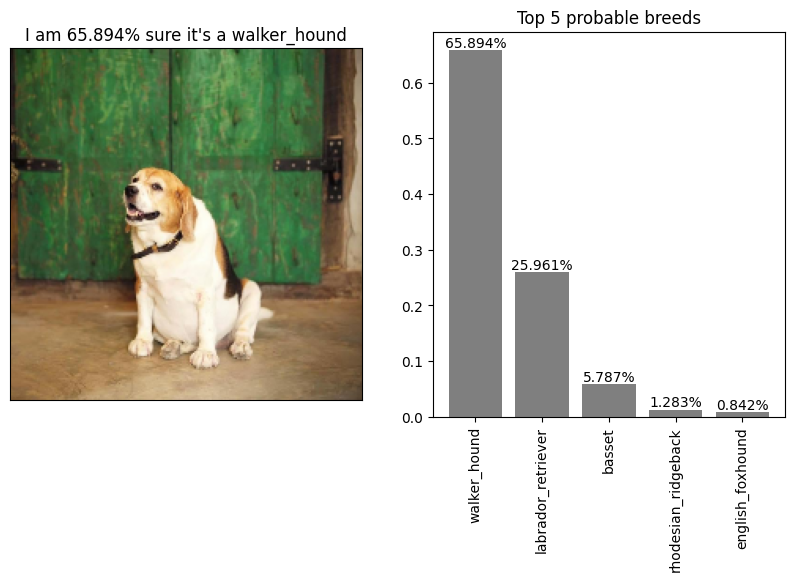

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


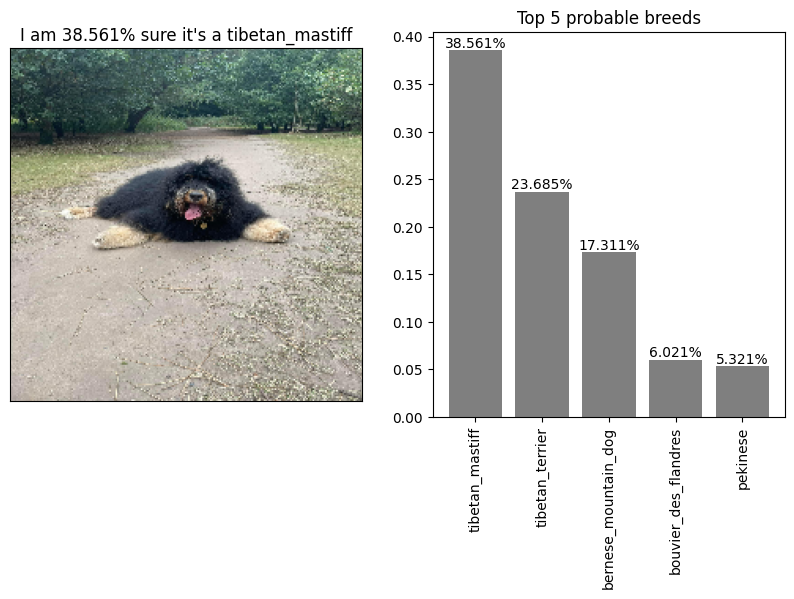

Prediction saved to 'IdentiBreed/user/output/' directory.
Thank you for your cooperation. This image will not be used for further training purposes.


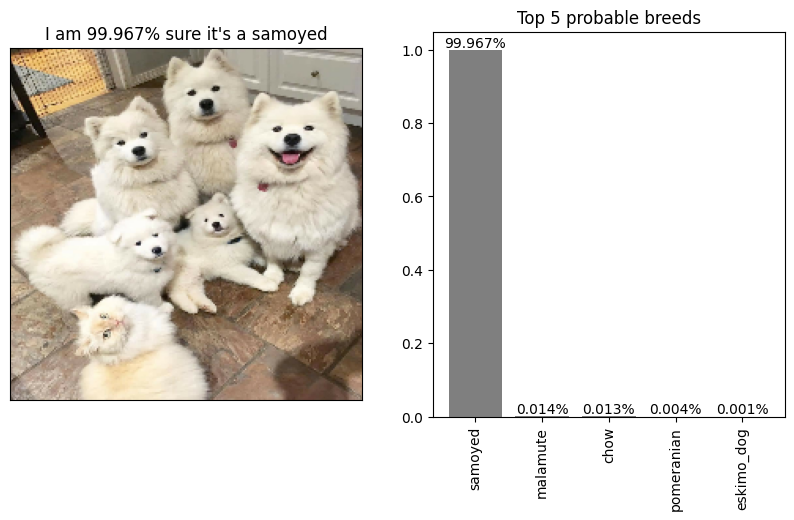

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


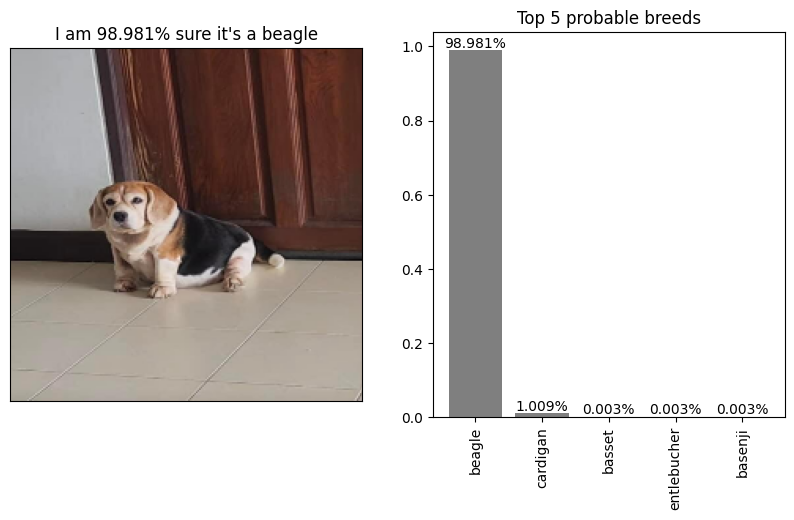

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


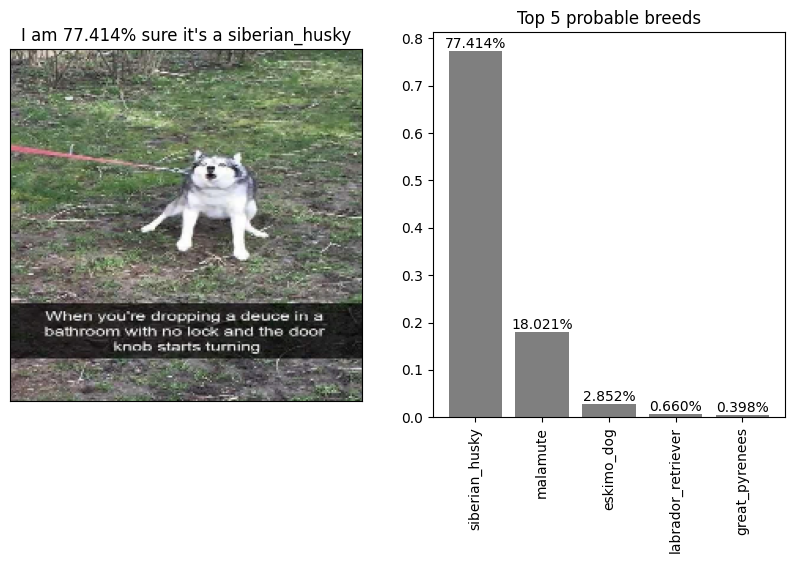

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


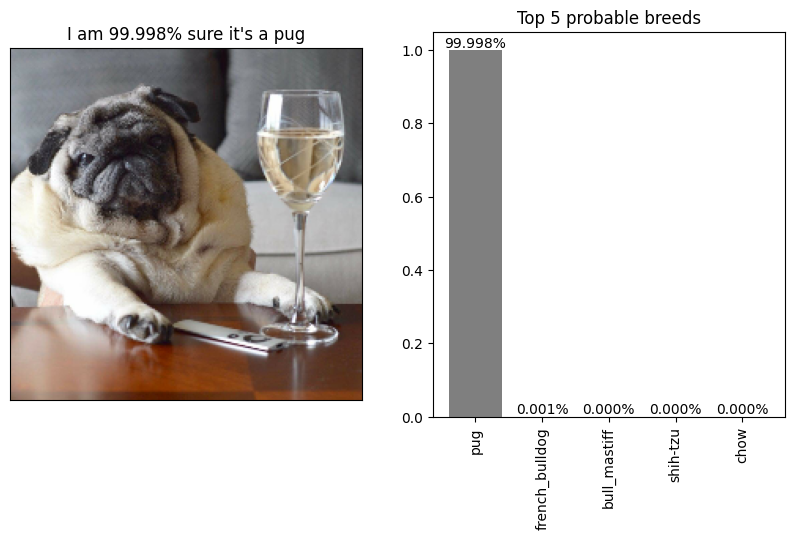

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


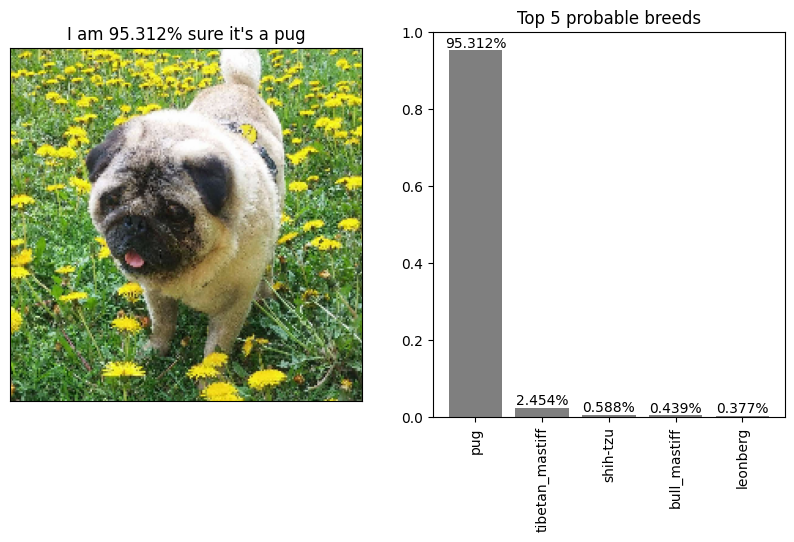

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


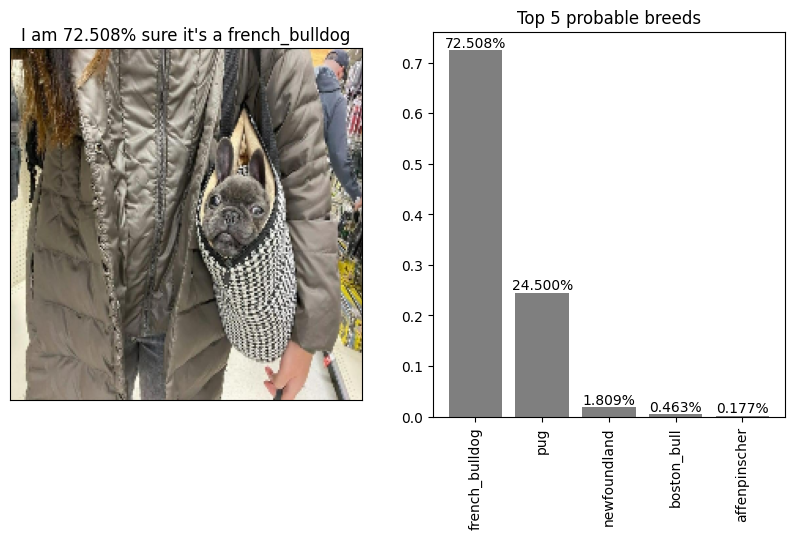

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


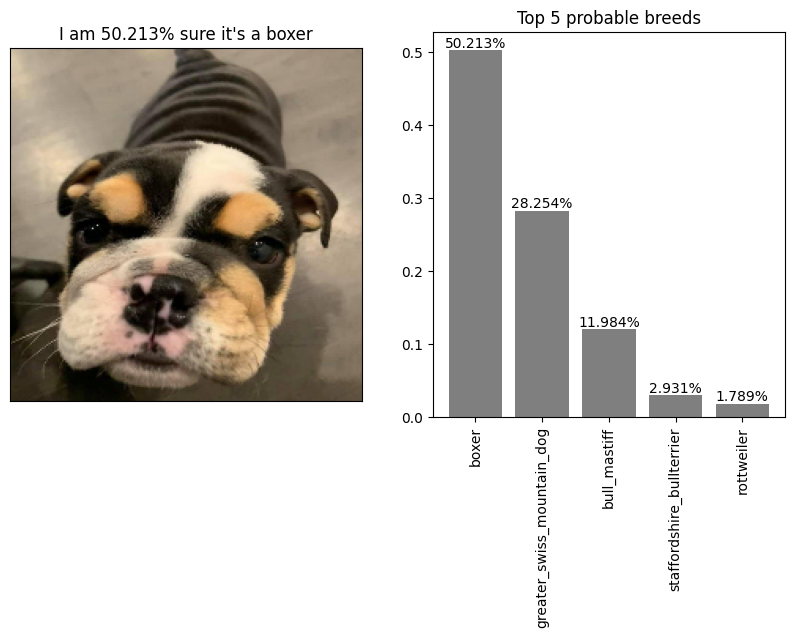

Prediction saved to 'IdentiBreed/user/output/' directory.
Error, please try again.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


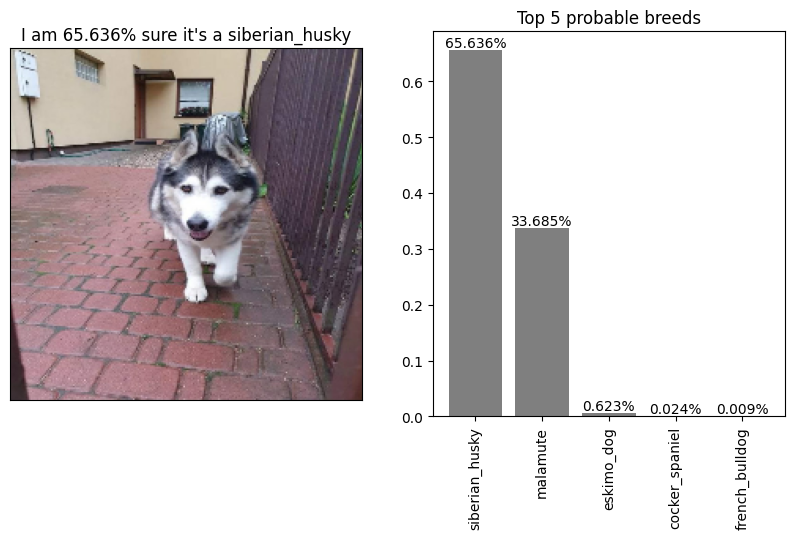

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


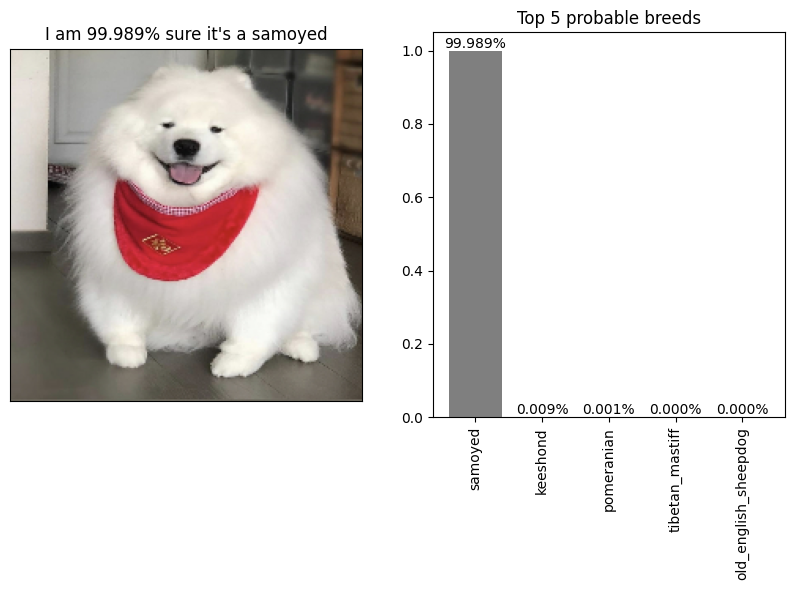

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


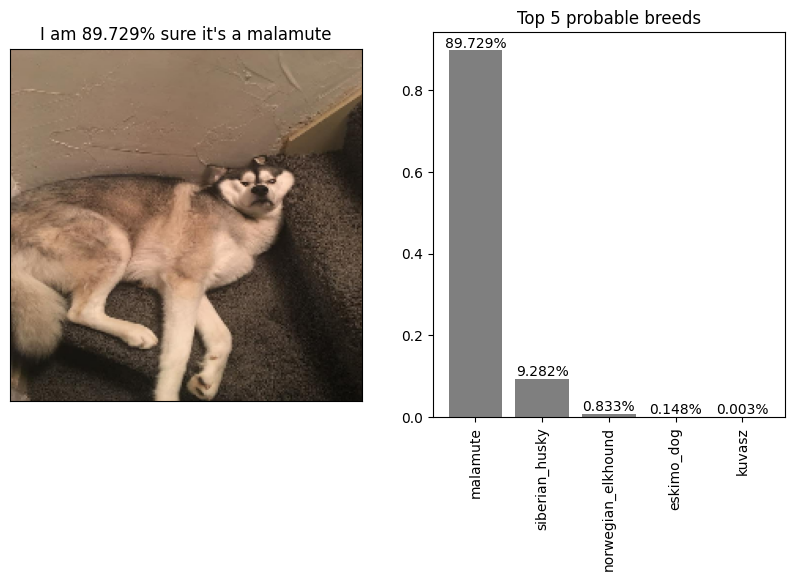

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


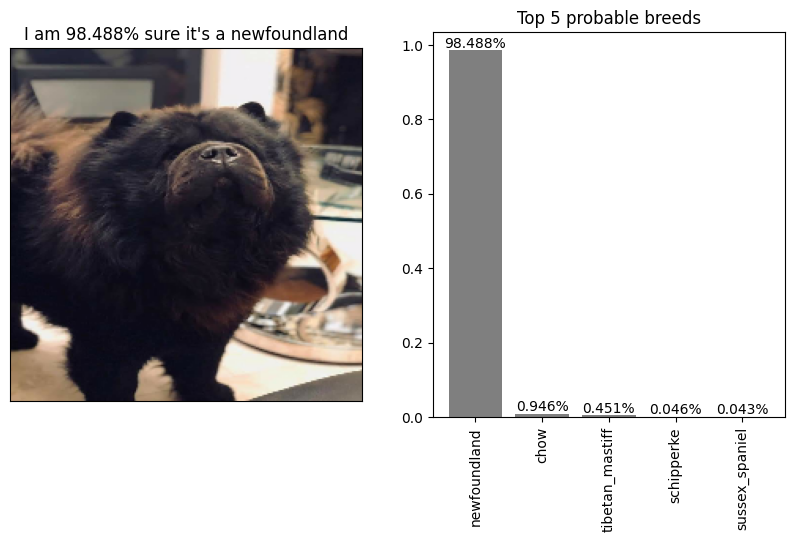

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


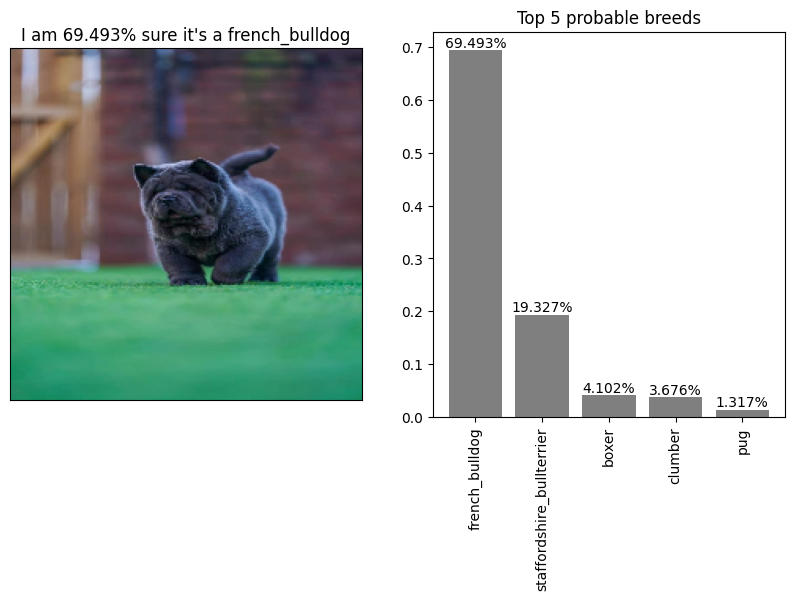

Prediction saved to 'IdentiBreed/user/output/' directory.
Currently images are only stored locally, they are not sent to the staff.
Adding image to the training dataset...


In [8]:
show_user_images("./user/input/")

Now as you can see the function asks user after each prediction if the model was correct and adds the image to the 'dataset' which really now is just a folder within the data folder.

That is it for the notebook. If you feel like it you can play with your own images here and see how this all works for youself. 

For now I am out, leaving this step behind. This notebook will be followed by a `user_funcs.py` file in the resources folder. It will contain all the functions defined here.

See you round!